In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import pickle
import matplotlib.pyplot as plt

from typing import Callable
from math import ceil
from tqdm import tqdm
from pylab import rcParams
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score as roc_auc, f1_score
from inspect import getfullargspec

%matplotlib inline
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8, 8

pd.options.display.max_columns = 100

In [2]:
df = pd.read_csv('train.csv', sep=';', on_bad_lines='skip')

df.sample(5)

,DateTime,Person_Id,Contract_Id,Account_Id,AccountPart_Id,Instrument_Id,Quantity,Number,ExternalAccount,Comments,ДатаДокумента,ВидДокумента,ВидОперации,НомерВходящегоДокумента,ДатаВходящегоДокумента,СуммаДокумента,ВалютаДокумента,СчетБанк,СчетОрганизации,СчетОрганизацииНомерСчета,СчетОрганизацииБанк,Контрагент,КонтрагентИНН,СчетКонтрагента,СчетКонтрагентаНомерСчета,СчетКонтрагентаБанк,СчетУчетаРасчетовСКонтрагентом,СубконтоДт1,СубконтоДт2,СубконтоДт3,СубконтоДт4,СубконтоДт5,СтатьяДвиженияДенежныхСредств,ЦеннаяБумага,НоменклатурнаяГруппа,НазначениеПлатежа,ДоговорКонтрагентаРасшифровкаПлатежа,СтатьяДвиженияДенежныхСредствРасшифровкаПлатежа,СуммаПлатежаРасшифровкаПлатежа,СтавкаНДСРасшифровкаПлатежа,СуммаНДСРасшифровкаПлатежа,СчетУчетаРасчетовСКонтрагентомРасшифровкаПлатежа,СчетУчетаРасчетовПоАвансамРасшифровкаПлатежа,СчетНаОплатуРасшифровкаПлатежа,НоменклатурнаяГруппаРасшифровкаПлатежа,ЦеннаяБумагаРасшифровкаПлатежа,СтрокаНайдена
3125,24.06.2024 0:00:00,2554,8857,172,39401,5,35500,5,40701810500001000812,Погашение номинала по облигациям частичное НАО...,24.06.2024 0:00:00,СписаниеСРасчетногоСчета,Перевод на другой счет организации,5.0,24.06.2024 0:00:00,35500,руб.,55.04,ВК_НКО НРД 810-3-10 депозитарный,40701810300010000812,044525505 НКО АО НРД,NaN,NaN,ВК_НКО НРД 40701810500001000812 брок.,40701810500001000812,044525505 НКО АО НРД,55.04,NaN,NaN,NaN,NaN,NaN,Перевод ДС со счета на счет,NaN,NaN,Погашение номинала по облигациям частичное НАО...,NaN,Перевод ДС со счета на счет,35500,NaN,0,NaN,NaN,NaN,NaN,NaN,Да
747,12.01.2024 0:00:00,2554,8857,145,39371,5,"8102,16",33,40701810300010000812,Дивиденды по акциям Microsoft Corporation. Зая...,12.01.2024 0:00:00,СписаниеСРасчетногоСчета,Перевод на другой счет организации,33.0,12.01.2024 0:00:00,"8102,16",руб.,55.04,ВК_НКО НРД 810-3-10 депозитарный,40701810300010000812,044525505 НКО АО НРД,NaN,NaN,ВК_НКО НРД 810-0-6 Москвин Ю.В.,40701810000006000812,044525505 НКО АО НРД,55.04,NaN,NaN,NaN,NaN,NaN,Перевод ДС со счета на счет,NaN,NaN,Дивиденды по акциям Microsoft Corporation. Зая...,NaN,Перевод ДС со счета на счет,"8102,16",20%,"1350,36",NaN,NaN,NaN,NaN,NaN,Да
11332,25.01.2024 0:00:00,2554,8498,124562,93579,29383,0,1624,70608810900004630108,1240125MOY3REV@ 01623 Переоценка - курсовая ра...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Нет
13897,31.01.2024 0:00:00,13462,11570,59858,59859,5,200,112730,70601810110002740200,Комиссия за отправление срочного перевода '31/...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Нет
7091,07.02.2024 0:00:00,2554,8857,73248,62127,5,"170,45",79,40701810200000000812,Оплата вознаграждения брокера за сделки на фон...,07.02.2024 0:00:00,СписаниеСРасчетногоСчета,Перевод на другой счет организации,79.0,07.02.2024 0:00:00,"170,45",руб.,55.04,ВК-НКО НРД 810-0-22 спец.брокерский,40701810000022000812,044525505 НКО АО НРД,NaN,NaN,ВК_НКО НРД 810-2-0 соб.,40701810200000000812,044525505 НКО АО НРД,55.04,NaN,NaN,NaN,NaN,NaN,Комиссия брокера,NaN,NaN,Оплата вознаграждения брокера за сделки на фон...,NaN,Комиссия брокера,"170,45",20%,"28,41",NaN,NaN,NaN,NaN,NaN,Да


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15240 entries, 0 to 15239
Data columns (total 47 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   DateTime                                          15240 non-null  object 
 1   Person_Id                                         15240 non-null  int64  
 2   Contract_Id                                       15240 non-null  int64  
 3   Account_Id                                        15240 non-null  int64  
 4   AccountPart_Id                                    15240 non-null  int64  
 5   Instrument_Id                                     15240 non-null  int64  
 6   Quantity                                          15240 non-null  object 
 7   Number                                            15240 non-null  object 
 8   ExternalAccount                                   15107 non-null  object 
 9   Comments         

### Поля которые нужно заполнить.
* ВидДокумента
* ВидОперации
* Контрагент
* СчетУчетаРасчетовСКонтрагентом
* Субконто1…5
* СтатьяДвиженияДенежныхСредств
* ЦеннаяБумага
* НоменклатурнаяГруппа

In [4]:
def data_vectorizer(data, column, vectorizer=None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer()
        # векторизация текстовых данных с помощью TF-IDF     
        X = vectorizer.fit_transform(data[column])   
    else:
        X = vectorizer.transform(data[column])   
    
    return pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names_out()), vectorizer    

In [5]:
def train_model(data, features, target):           
    X = data[features]
    y = data[target]
    
    model = LogisticRegression() 
    model.fit(X, y)    
    
    return model

In [6]:
data = df[~df["ВидОперации"].isna()]

In [7]:
data.shape

(8273, 47)

In [8]:
# выполним label-encoding
encoder = LabelEncoder().fit(data['ВидДокумента'])
data['ВидДокументаEnc'] = encoder.transform(data['ВидДокумента'])
encoder = LabelEncoder().fit(data['ВидОперации'])
data['ВидОперацииEnc'] = encoder.transform(data['ВидОперации'])

data_vectorize, vectorizer = data_vectorizer(data=data, column='Comments')
data = pd.concat([data, data_vectorize], axis=1)

#data = data.fillna(data['ExternalAccount'].mode()[0]) 
#data['ExternalAccountEnc'] = LabelEncoder().fit_transform(data['ExternalAccount'])

# делим набор для начала активного обучения
train_data, valid_data = train_test_split(data, train_size=0.2, random_state=42)
columns = list(data_vectorize.columns)
columns.append('Person_Id')
columns.append('Contract_Id')
columns.append('Account_Id')
columns.append('AccountPart_Id')
columns.append('ВидДокументаEnc')
# обучение модели
model = train_model(train_data, columns, 'ВидОперацииEnc')
# формируем итоговый набор с предсказанными классами
X = valid_data[columns]
y_predicted = model.predict(X) 
#auc = roc_auc_score(valid_data['ВидОперацииEnc'], y_predicted, average='micro')
f1 = f1_score(valid_data['ВидОперацииEnc'], y_predicted, average='micro')
print(f1)
# результат
df = pd.concat([pd.DataFrame(encoder.inverse_transform(y_predicted), columns=['ВидОперации']), valid_data], axis=1)
df.sample(10)

0.4002115123130382


,ВидОперации,DateTime,Person_Id,Contract_Id,Account_Id,AccountPart_Id,Instrument_Id,Quantity,Number,ExternalAccount,Comments,ДатаДокумента,ВидДокумента,ВидОперации,НомерВходящегоДокумента,ДатаВходящегоДокумента,СуммаДокумента,ВалютаДокумента,СчетБанк,СчетОрганизации,СчетОрганизацииНомерСчета,СчетОрганизацииБанк,Контрагент,КонтрагентИНН,СчетКонтрагента,СчетКонтрагентаНомерСчета,СчетКонтрагентаБанк,СчетУчетаРасчетовСКонтрагентом,СубконтоДт1,СубконтоДт2,СубконтоДт3,СубконтоДт4,СубконтоДт5,СтатьяДвиженияДенежныхСредств,ЦеннаяБумага,НоменклатурнаяГруппа,НазначениеПлатежа,ДоговорКонтрагентаРасшифровкаПлатежа,СтатьяДвиженияДенежныхСредствРасшифровкаПлатежа,СуммаПлатежаРасшифровкаПлатежа,СтавкаНДСРасшифровкаПлатежа,СуммаНДСРасшифровкаПлатежа,СчетУчетаРасчетовСКонтрагентомРасшифровкаПлатежа,СчетУчетаРасчетовПоАвансамРасшифровкаПлатежа,СчетНаОплатуРасшифровкаПлатежа,НоменклатурнаяГруппаРасшифровкаПлатежа,ЦеннаяБумагаРасшифровкаПлатежа,СтрокаНайдена,ВидДокументаEnc,ВидОперацииEnc,...,цод,части,частичная,частично,частичное,частичном,часть,через,черкизово,черногорэнерго,числе,чтпз,шашина,шд,шкафа,штрафа,ый,эйч,экзамена,экземпляров,эко,экспертиза,эл,электрической,электромагистраль,электронном,электронным,электронных,электрорешения,эм,энергетическая,энергоника,энергосбыт,энерготехсервис,эр,эс,эсэфай,эталон,эф,ювелит,югры,юл,юридические,якутия,якутская,январе,январь,январь2024,января,ятэк
3247,Перевод на другой счет организации,08.05.2024 0:00:00,2554.0,8857.0,172.0,39401.0,5.0,"79894,43",4,40701810500001000812,"Купонный доход по облигациям ООО ""Неолизинг"". ...",08.05.2024 0:00:00,СписаниеСРасчетногоСчета,Перевод на другой счет организации,4.0,08.05.2024 0:00:00,"79894,43",руб.,55.04,ВК_НКО НРД 810-3-10 депозитарный,40701810300010000812,044525505 НКО АО НРД,NaN,NaN,ВК_НКО НРД 40701810500001000812 брок.,40701810500001000812,044525505 НКО АО НРД,55.04,NaN,NaN,NaN,NaN,NaN,Перевод ДС со счета на счет,NaN,NaN,"Купонный доход по облигациям ООО ""Неолизинг"". ...",NaN,Перевод ДС со счета на счет,"79894,43",20%,"13315,74",NaN,NaN,NaN,NaN,NaN,Да,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2793,Перевод на другой счет организации,10.01.2024 0:00:00,2554.0,8857.0,172.0,39401.0,5.0,"46919,74",1,40701810000006000812,Исполнение обязательств по Указу Президента 66...,10.01.2024 0:00:00,СписаниеСРасчетногоСчета,Перевод на другой счет организации,1.0,10.01.2024 0:00:00,"46919,74",руб.,55.04,ВК_НКО НРД 810-3-10 депозитарный,40701810300010000812,044525505 НКО АО НРД,NaN,NaN,ВК_НКО НРД 810-0-6 Москвин Ю.В.,40701810000006000812,044525505 НКО АО НРД,55.04,NaN,NaN,NaN,NaN,NaN,Перевод ДС со счета на счет,NaN,NaN,Исполнение обязательств по Указу Президента 66...,NaN,Перевод ДС со счета на счет,"46919,74",20%,"7819,96",NaN,NaN,NaN,NaN,NaN,Да,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4151,Перевод на другой счет организации,11.06.2024 0:00:00,2554.0,8855.0,39339.0,39340.0,5.0,50,529271,70601810110002740200,Комиссия за расчетные операции '11/06/2024',11.06.2024 0:00:00,СписаниеСРасчетногоСчета,Прочее списание,529271.0,11.06.2024 0:00:00,50,руб.,51.00,ВК_МКБ 810-3 соб.,40701810300760004054,"044525659 ПАО ""МОСКОВСКИЙ КРЕДИТНЫЙ БАНК""",Московский Кредитный Банк ПАО,7.734203e+09,NaN,NaN,NaN,91.02,Расходы по расчетному и кассовому обслуживанию...,NaN,NaN,NaN,NaN,Комиссия банка Дт сч.91.02,NaN,NaN,Комиссия за расчетные операции '11/06/2024',NaN,Комиссия банка Дт сч.91.02,50,NaN,0,NaN,NaN,NaN,NaN,NaN,Да,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000

In [9]:
class DataFrame(pd.DataFrame):
    """расширение DataFrame"""
    @property    
    def columns_num(self):
        """количественные признаки"""
        return self[self.columns.tolist()].select_dtypes(include=['uint8', 'int32', 'int64', 'float32', 'float64']).columns.tolist()
        
    @property    
    def columns_cat(self):
        """номинативные признаки"""
        return self[self.columns.tolist()].select_dtypes(include=['object', 'category']).columns.tolist()

    @property
    def columns_txt(self):
        return self[[item for item in self.columns_cat if any(self[item].str.split().str.len() > 2)]].columns.tolist()        
    
    def columns_except(self, columns, excepts):
        return self[[item for item in columns if item not in excepts]]
    
class DataPipeline:     
    def __init__(self, **kwargs):
        """Инициализация класса"""                 
        # уровень стат значимости
        self.alpha = 0.05
        # срнднйи уровень корреляции
        self.corr = 0.7
        # объясненная дисперсия компонента
        self.varatio = 0.8
        # пороговое значение в три сигмы
        self.threashold = 3    
        # пропорции деления набора
        self.test_size = 0.33
        # кодировщики
        self.__encoders__ = dict()
        # модели
        self.__models__ = dict()
        
        # параметры класса
        for key, value in kwargs.items():
            setattr(self, f"__{key}__", value)    
            
        assert self.__target__ is not None                  
        assert self.__features__ is not None                  
        assert self.__train_data__ is not None                    

    def __getstate__(self) -> dict:
        state = dict()    

        state["encoders"] = self.__encoders__
        state["models"] = self.__models__
        state["features"] = self.__features__
        state["target"] = self.__target__        
        
        return state
    
    def __setstate__(self, state: dict):            
        self.__encoders__ = state["encoders"]
        self.__models__ = state["models"]
        self.__features__ = state["features"]
        self.__target__ = state["target"]     
    
    def sc_data(func: Callable):
        """Декоратор стандартизации"""
        def wrapper(self, data, target):                     
            # стандартизация обучения                    
            self.__sc_train_data__ = func(self, data, target)                  
            # исключение целевой переменной из количественных признаков            
            column = self.__sc_train_data__.columns_except(self.__sc_train_data__.columns_num, target).columns
            # создаем стандартизатор
            scaler = f"scaler_{target}"
            if scaler not in self.__encoders__:
                self.__encoders__[scaler] = StandardScaler()        
                self.__encoders__[scaler].fit(self.__sc_train_data__[column])                           
            # стандартизация признаков                                     
            self.__sc_train_data__ = DataFrame(pd.concat([DataFrame(self.__encoders__[scaler].transform(self.__sc_train_data__[column]), columns=column, index=self.__sc_train_data__.index),\
                                                     self.__sc_train_data__[self.__sc_train_data__.columns_cat]], axis=1))                                                                         
                        
        return wrapper    
    
    @sc_data
    def transform(self, data, target):               
        """Трансформация данных"""           
        # подготовка обучения                    
        data = DataFrame(data[self.__features__ + [target]])
        data = DataFrame(data[~data[target].isna()])              
        # заменяем inf на nan тогда моедль сможет их предсказать
        data.replace([np.inf, -np.inf], np.nan, inplace = True)
        
        # обработка количественных признаков    
        for item in data.columns_num:            
            data = self._transform_num_(data, item, target)                                                                                                     

        # векторизация текстовых признаков    
        for item in data.columns_txt:            
            data = self._transform_vec_(data, item, target)            
        
        # обработка номинальных признаков
        for item in data.columns_cat:                   
            data = self._transform_cat_(data, item, target)                    
        
        return data

    def _transform_vec_(self, data, column, target):        
        """Векторизация текстовых признаков"""                                 
        if column not in self.__features__:
            return data
            
        data[column] = data[column].fillna(data[column].mode()[0])                    
        # singlton кодировщика
        if column not in self.__encoders__:                
            self.__encoders__[column] = TfidfVectorizer()        
            self.__encoders__[column].fit(data[column])                                        
        # векторизация текстового признака
        vect = self.__encoders__[column].transform(data[column])                 
        # преобразование в DataFrame        
        return DataFrame(pd.concat([data.columns_except(data.columns, column),\
                                   DataFrame(vect.todense(), columns=self.__encoders__[column].get_feature_names_out(), index=data.index)], axis=1))                                                

    def _transform_cat_(self, data, column, target):
        """Трансформация номинальных признаков"""                         
        # заменяем пропуски модой                                   
        data[column] = data[column].fillna(data[column].mode()[0])                    
        # создаем кодировщик
        if column not in self.__encoders__:
            self.__encoders__[column] = LabelEncoder()        
            self.__encoders__[column].fit(data[column])                    
        # кодируем признак                         
        data[column] = self.__encoders__[column].transform(data[column])                    
        # возвращаем тип признака из числового после кодирования
        data[column] = data[column].astype("category")
        
        return data        
        
    def _transform_num_(self, data, column, target):        
        """Трансформация количественных признаков"""        
        if len(data) == 1:
            return data
        # пробуем предсказать пропуски                        
        cdata = DataFrame(data.copy()) 
        # запомнинание пропусков        
        cdata['isna'] = np.where(cdata[column].isna(), True, False)                                             
        # заполнение пропусков в копии, т.к моедель не работает с ними
        for item in cdata.columns_cat:            
            if cdata[item].isna().values.any():
                cdata[item] = cdata.fillna(cdata[item].mode())        
        for item in cdata.columns_num:
            if cdata[item].isna().values.any():
                cdata[item] = cdata.fillna(cdata[item].mean())                   
        # предсказание пропусков если можно сформировать обучающий и тестовый набор
        if True in cdata['isna'].values and False in cdata['isna'].values:
            # используем простую модель
            model = LinearRegression()
            # формируем тестовый и обучающий набор
            X_test = cdata.columns_except(cdata.columns, column)[cdata['isna']==True]
            X_train = cdata.columns_except(cdata.columns, column)[cdata['isna']==False]
            y_train = cdata[cdata['isna']==False][column]                    
            # обучение модели
            model.fit(X_train, y_train)
            # выполняем предсказание пропущенного прзнака        
            data.loc[cdata['isna'], [column]] = model.predict(X_test)                                      
        
        # винсоризацию уелевой переменной    
        if column == target:            
            data[column] = winsorize(data[column], limits=[0.1, 0.1])                                                            
        
        # обработка выбрасов, вычисляем z-Score в цикле пока не подавим их все       
        while column != target:            
            z = np.abs(stats.zscore(data[column]))                                                     
            if not z[z > self.threashold].any():
                break            
            # среднее если данные имеют нормальное распределение, иначе медиана                                    
            if stats.shapiro(data[column].values.reshape(-1))[1] > self.alpha:                        
                data.loc[z > self.threashold, column] = data[column].mean()            
            else:            
                data.loc[z > self.threashold, column] = data[column].median()                                                          
        
        return data          
    
    def _resize_(self, data, level = 0):
        """понижение размерности"""           
        m_corr, level = data.corr(), level + 1        
        for item in m_corr.columns:            
            # поиск взаимокорреляции признаков по матрице
            column = list(m_corr[m_corr[item] > self.corr].index)
            # корреляция не с самим собой и не одни компоненты 
            if len(column) > 1 and not all('component' in item for item in column):
                dim_reducer = PCA(n_components=1, random_state=42)                
                components = dim_reducer.fit_transform(data[column])                            
                # уровень дисперсии достаточен для свертывания
                if dim_reducer.explained_variance_ratio_ >= self.varatio:
                    data = DataFrame(pd.concat([data.drop(column, axis=1),\
                                                pd.DataFrame(data = components, columns = [f'component_{level}'])], axis=1))                                                                                                
                    # результат свертки
                    print(f'{column} -> component_{level} var:{dim_reducer.explained_variance_ratio_}')
                    # рекурсивный поиск компонент
                    return self._resize_(data, level)               
        return data     

    @property
    def train_data(self):
        return DataFrame(self.__train_data__)
        
    @property
    def sc_train_data(self):
        return DataFrame(self.__sc_train_data__)

    @property
    def target(self):
        return self.__target__
        
    @property
    def encoders(self):
        return self.__encoders__          
    
    @property
    def models(self):
        return self.__models__        
    
    def split(self, X, y):
        """Разделение набора"""             
        return train_test_split(X, y, test_size=self.test_size, random_state=42)
    
    def search_param(self, model, data, target):
        """Поиск гиперпараметров"""   
        if isinstance(model, LogisticRegression):            
            params = {                
                'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
                'C' : np.logspace(-4,4,20),
                'max_iter'  : [100,1000,2500,5000]
            }            
     
            clf = GridSearchCV(
                estimator=LogisticRegression(random_state=42),
                param_grid=params,            
                scoring='f1',
                verbose=True,
                n_jobs=-1,
                cv=3
            )                                           
        elif isinstance(model, RandomForestClassifier):
            params = {
                'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson', 'gini', 'entropy'],
                'n_estimators': [item for item in range(10, 100, 10)],            
                'max_depth': [item for item in range(1, 10, 2)],
                'max_features': [item for item in range(1, 10, 2)],
                'min_samples_leaf': [item for item in range(1, 10, 2)],
            }
    
            clf = GridSearchCV(
                estimator=RandomForestClassifier(random_state=42),
                param_grid=params,            
                scoring='f1',
                n_jobs=-1,
                cv=5
            )                   
        # формируем X и y из обучающего набора
        X_train, X_valid, y_train, y_valid = self.split(data, data[target])
        # искать праметры лучше на всеъ данных
        clf.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))
        
        return clf.best_params_
    
    def fit(self, model, data, target):
        """Обучение модели"""                     
        self.__models__[target] = model
        # разделение набора на обучающий и проверочный
        X_train, X_valid, y_train, y_valid = self.split(data.columns_except(data.columns, target), data[target])        
        
        self.__models__[target].fit(X_train, y_train)                        
        
        return self.__models__[target]
        
    def predict(self, model, data):
        """Предсказание зависимой переменной"""        
        return model.predict(data.columns_except(data.columns, self.__target__))    
    
    def importances(self, model, data):
        """оценка признаков модели"""                                
        return pd.DataFrame(zip(data.columns_except(data.columns, self.__target__).columns, model.feature_importances_),\
                            columns = ['name', 'value']).sort_values(by = 'value', ascending = False)                          
    
    def scatterplot(self, model, data, target):
        """график scatterplot качесива модели"""    
        X_train, X_valid, y_train, y_valid = self.split(data.columns_except(data.columns, target), data[target])

        y_pred = self.predict(model, DataFrame(X_train))    
        
        plt.subplot(121)
        plt.xlabel('Predicted values')
        plt.ylabel('True values')                
        plt.title(f"train f1:{round(f1_score(y_train, y_pred, average='micro'), 3)}")        
        #plt.title(f"train auc:{round(roc_auc(y_train, y_pred, multi_class='ovr', average='micro'), 3)}")        
        sns.scatterplot(x = y_train, y = y_pred)
        
        y_pred = self.predict(model, DataFrame(X_valid))        
        
        plt.subplot(122)
        plt.xlabel('Predicted values')
        plt.ylabel('True values')                
        plt.title(f"valid f1:{round(f1_score(y_valid, y_pred, average='micro'), 3)}")     
        #plt.title(f"train auc:{round(roc_auc(y_valid, y_pred, multi_class='ovr', average='micro'), 3)}")        
        sns.scatterplot(x = y_valid, y = y_pred)
        
        plt.show()                      

    def boxplot(self, data):
        """график box-plot"""                           
        data.boxplot(column = data.columns_num, grid = False, rot = 45)
        
    def corrplot(self, data):
        """график корреляции"""              
        plt.title('Корреляционная матрица')
        sns.heatmap(data.corr(), annot = True)
        plt.show()

%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
# загрузка обучающего набора
train_data = DataFrame(pd.read_csv("train.csv", sep=';', on_bad_lines='skip')).sample(frac = 1)[:1000]
pipeline = DataPipeline(train_data=train_data, features=['Person_Id','Contract_Id','Account_Id','AccountPart_Id','Comments'], target='Контрагент')    
pipeline.transform(pipeline.train_data)    
# поиск гиперпараметров
print(pipeline.search_param(LogisticRegression(), pipeline.sc_train_data))

  0%|                                                                                                          | 0/11 [00:00<?, ?it/s]

ВидДокумента


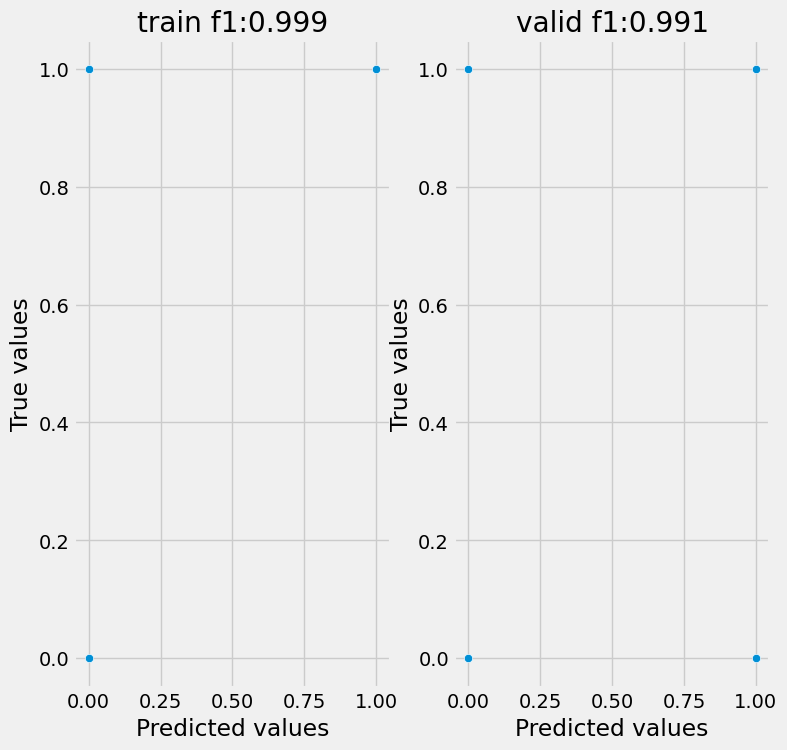

  9%|████████▉                                                                                         | 1/11 [00:05<00:53,  5.36s/it]

ВидОперации


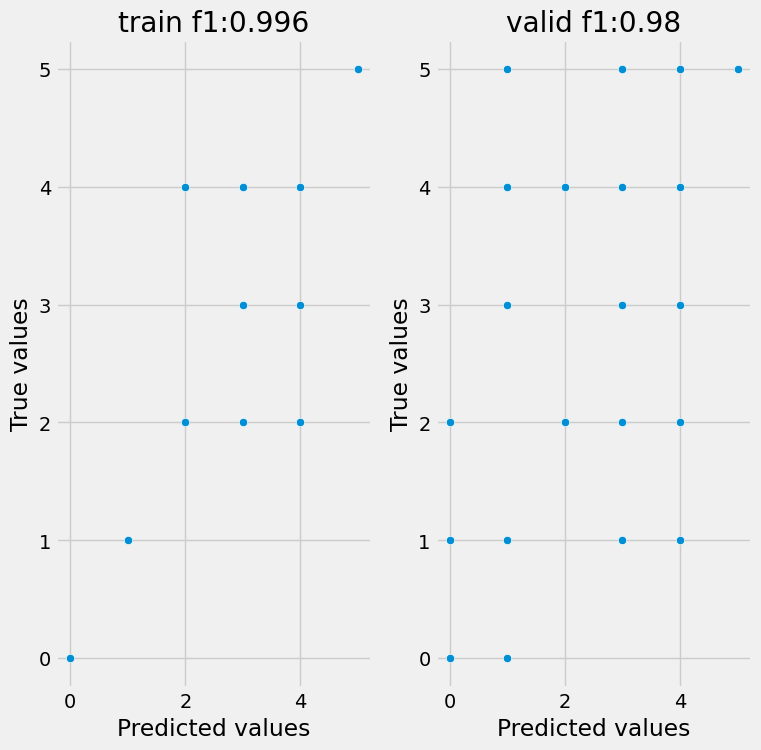

 18%|█████████████████▊                                                                                | 2/11 [00:15<01:15,  8.37s/it]

Контрагент


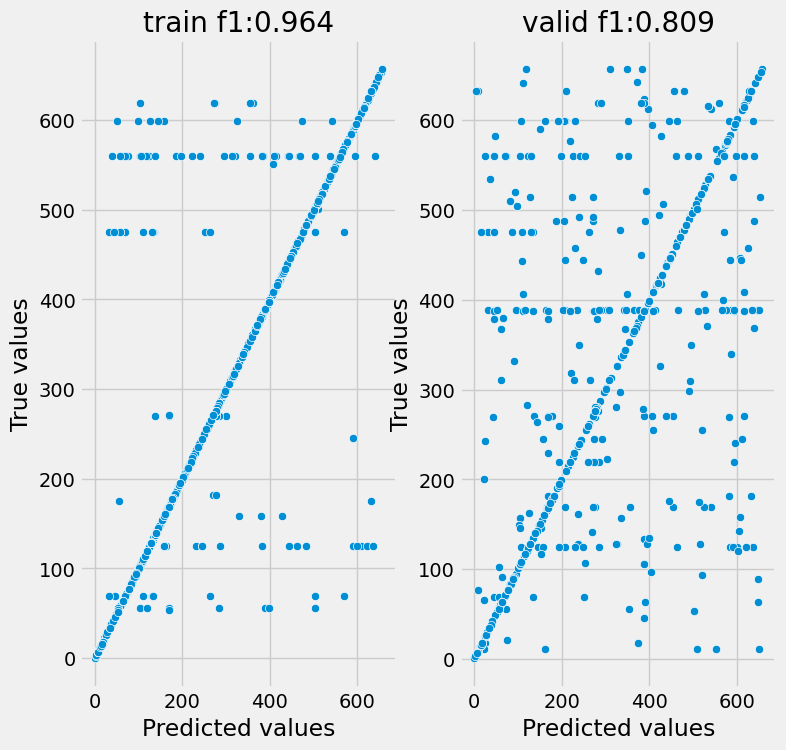

 27%|██████████████████████████▋                                                                       | 3/11 [01:22<04:40, 35.11s/it]

СчетУчетаРасчетовСКонтрагентом


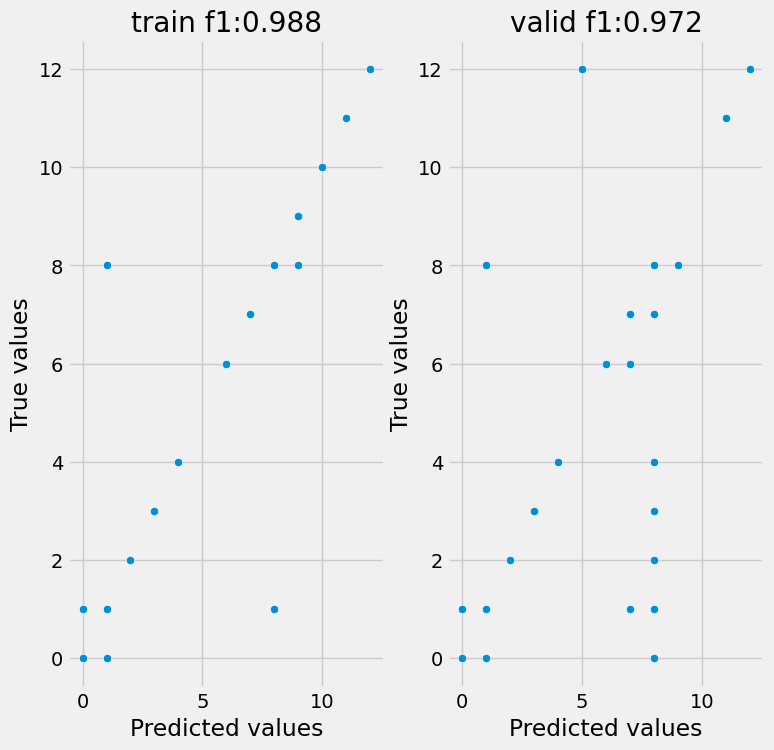

 36%|███████████████████████████████████▋                                                              | 4/11 [01:28<02:44, 23.51s/it]

СтатьяДвиженияДенежныхСредств


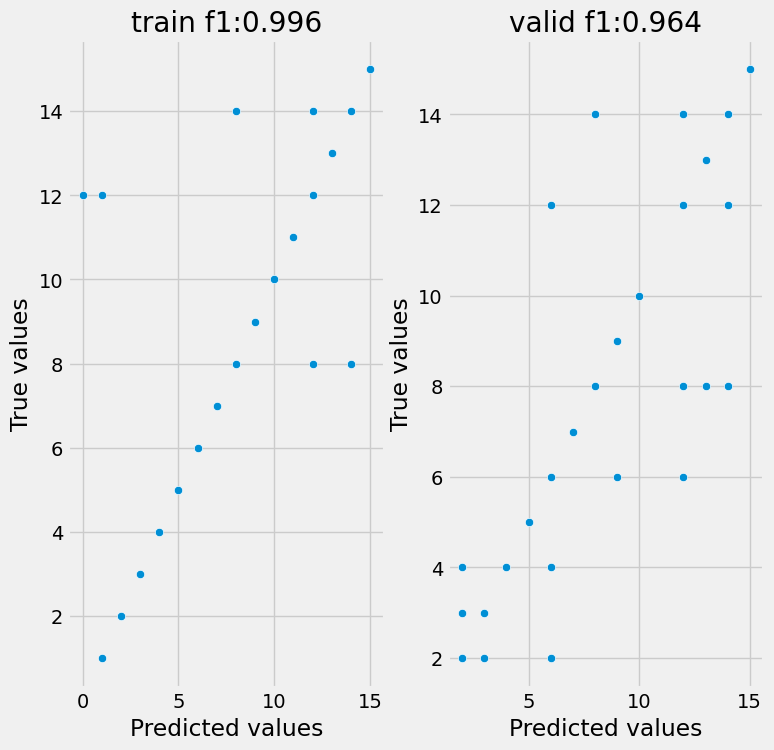

 45%|████████████████████████████████████████████▌                                                     | 5/11 [01:34<01:44, 17.35s/it]

ЦеннаяБумага


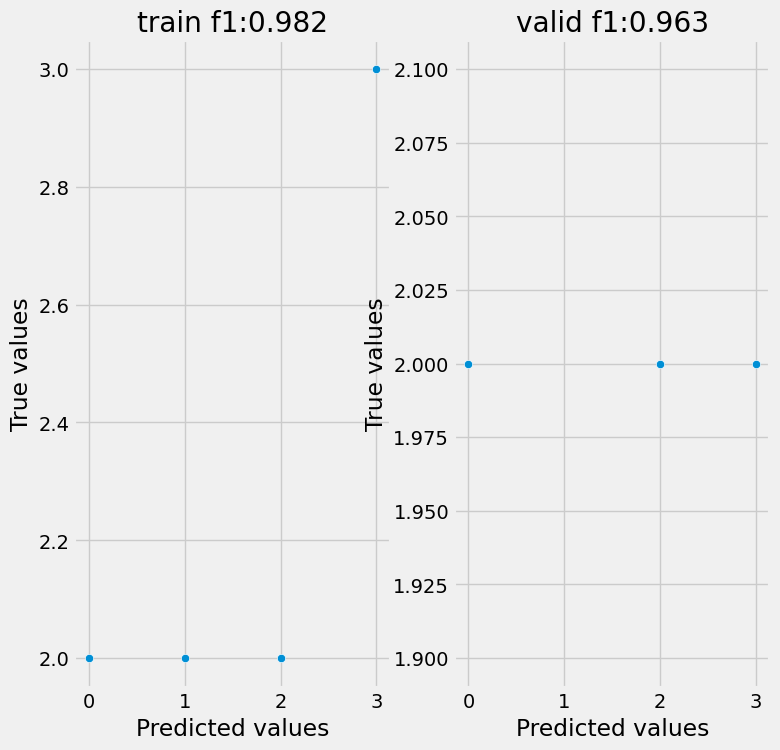

 55%|█████████████████████████████████████████████████████▍                                            | 6/11 [01:35<00:58, 11.65s/it]

НоменклатурнаяГруппа


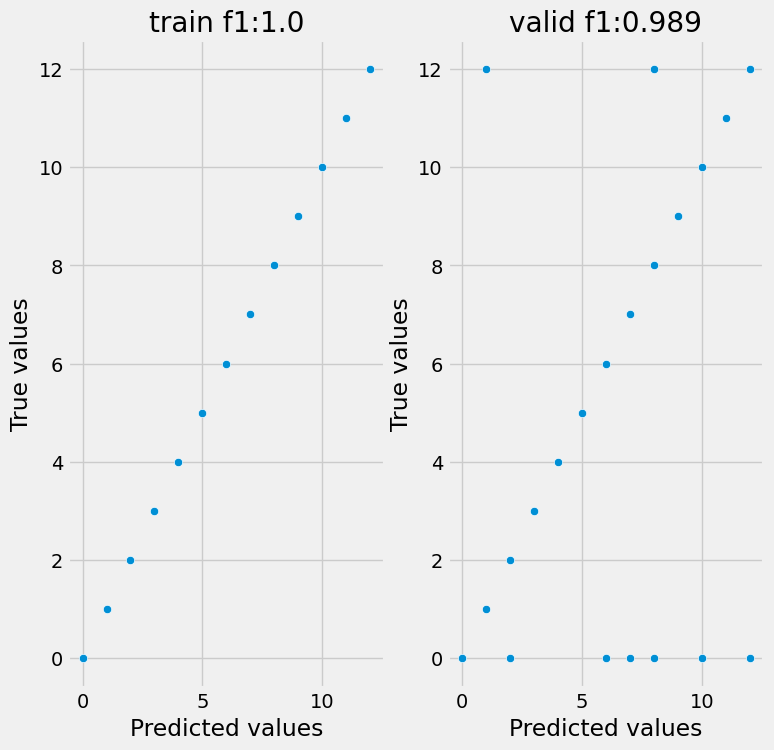

 64%|██████████████████████████████████████████████████████████████▎                                   | 7/11 [01:37<00:34,  8.63s/it]

СубконтоДт1


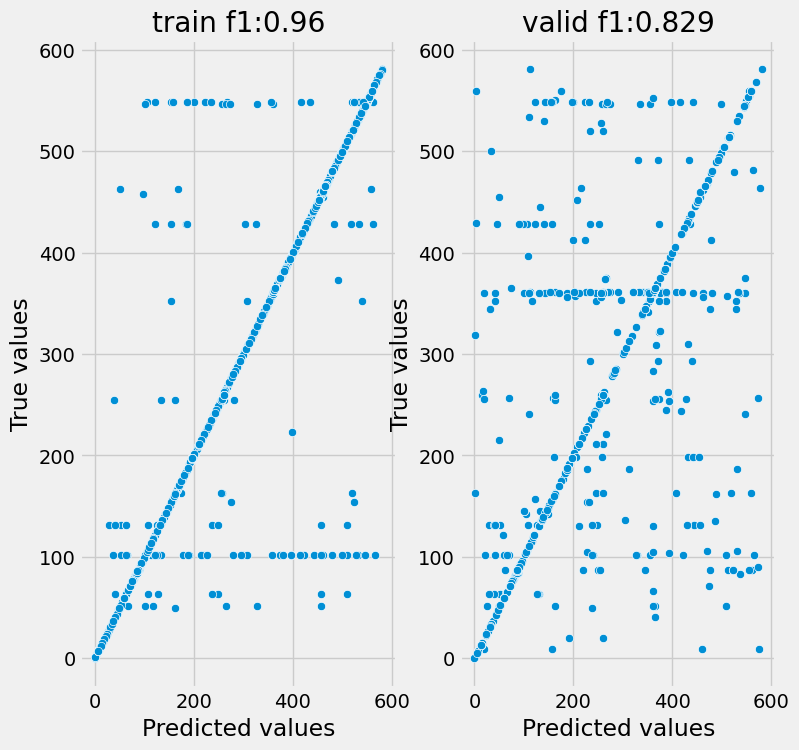

 73%|███████████████████████████████████████████████████████████████████████▎                          | 8/11 [02:24<01:02, 20.76s/it]

СубконтоДт2


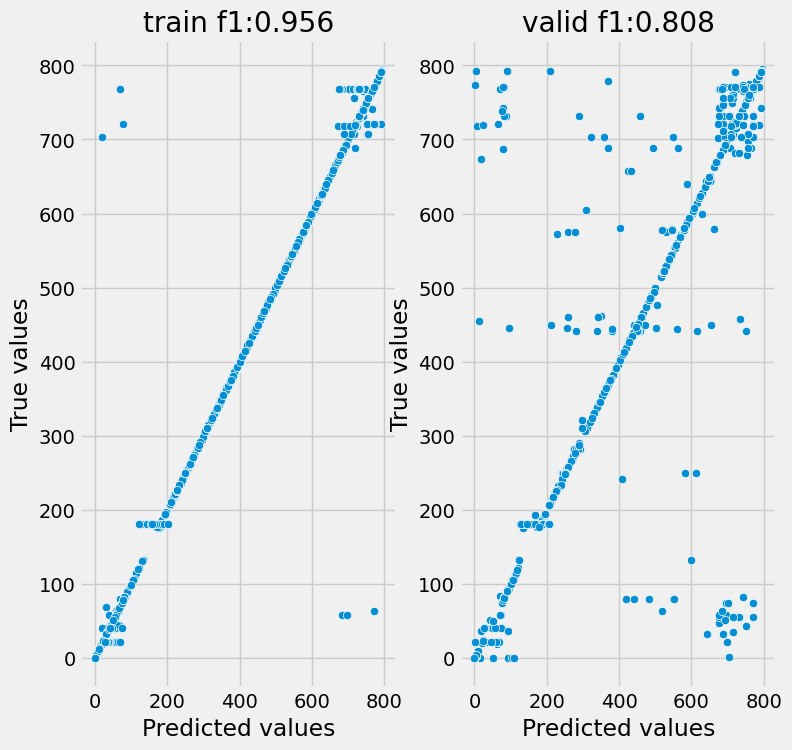

 82%|████████████████████████████████████████████████████████████████████████████████▏                 | 9/11 [03:24<01:06, 33.11s/it]

СубконтоДт3


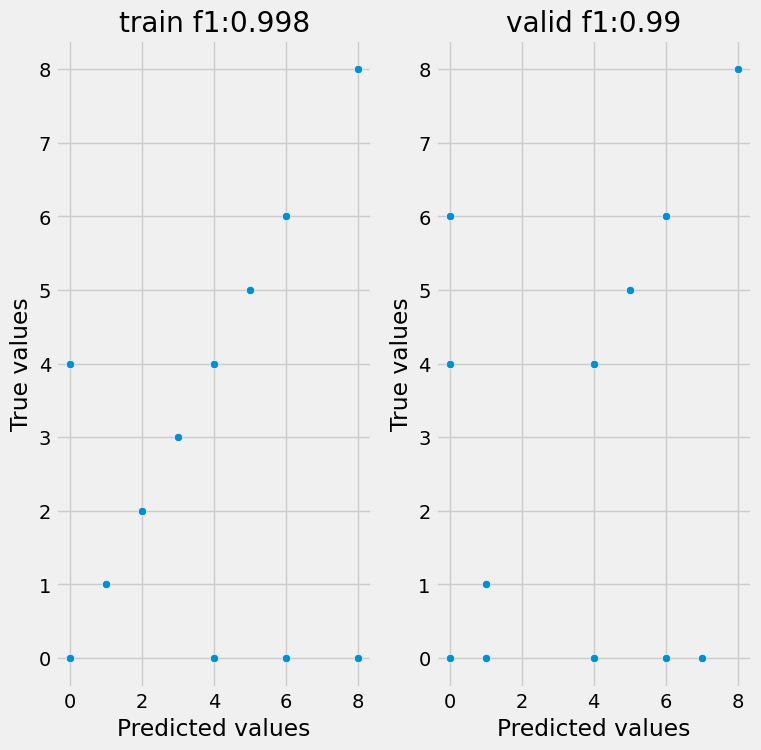

 91%|████████████████████████████████████████████████████████████████████████████████████████▏        | 10/11 [03:28<00:23, 23.93s/it]

СубконтоДт4


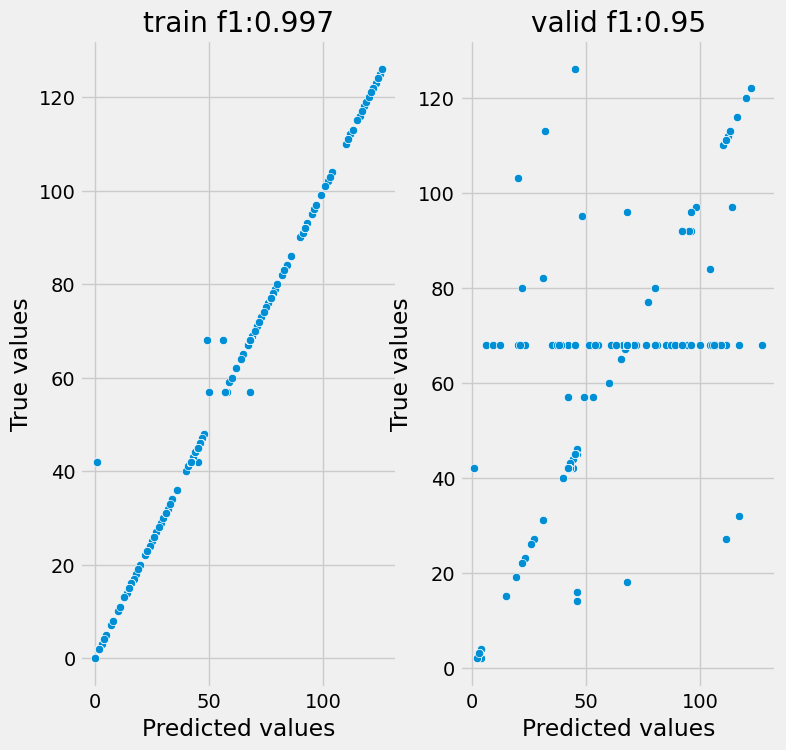

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [03:39<00:00, 19.99s/it]


CPU times: total: 20min 23s
Wall time: 3min 46s


In [10]:
%%time
# загрузка обучающего набора
train_data = DataFrame(pd.read_csv("train.csv", sep=';', on_bad_lines='skip'))
pipeline = DataPipeline(train_data=train_data, features=['Person_Id','Contract_Id','Account_Id','AccountPart_Id','Comments'], target=['ВидДокумента','ВидОперации','Контрагент',\
                                                                                                                                      'СчетУчетаРасчетовСКонтрагентом','СтатьяДвиженияДенежныхСредств','ЦеннаяБумага','НоменклатурнаяГруппа',\
                                                                                                                                      'СубконтоДт1','СубконтоДт2','СубконтоДт3','СубконтоДт4'])
# обучения моделей для каждого целевой переменной
for target in tqdm(pipeline.target):
    print(target)            
    pipeline.transform(pipeline.train_data, target)    
    #pipeline.fit(LogisticRegression(**{'C': np.float64(0.0001), 'max_iter': 100, 'solver': 'lbfgs'}), pipeline.sc_train_data)
    model = pipeline.fit(LogisticRegression(), pipeline.sc_train_data, target)
    pipeline.scatterplot(model, pipeline.sc_train_data, target)
# сериализация модели в файл
with open("pipeline.pkl", "wb") as f:
    pickle.dump(pickle.dumps(pipeline), f)

In [11]:
#params = pipeline.search_param(pipeline.sc_train_data) 
#params = {'criterion': 'gini',  'max_depth': 9,  'max_features': 5,  'min_samples_leaf': 1,  'n_estimators': 90}
#model = pipeline.fit(RandomForestClassifier(**params), pipeline.sc_train_data)

In [12]:
# загрузка набора
data = DataFrame(pd.read_csv("train.csv", sep=';', on_bad_lines='skip'))
# загрузка конвейера
with open("pipeline.pkl", "rb") as f:
    pipeline = pickle.loads(pickle.load(f))
# загрузка target кодировщика
encoder = pipeline.encoders['ВидДокумента']
# предсказание
pipeline.transform(data[:1], 'ВидДокумента')
print(encoder.inverse_transform(pipeline.predict(pipeline.models['ВидДокумента'], pipeline.sc_train_data)))

['СписаниеСРасчетногоСчета']


In [13]:
import json
# загрузка набора
data = DataFrame(pd.read_csv("train.csv", sep=';', on_bad_lines='skip'))
data_json = data[:1].to_json(orient="records", lines=True)
data = DataFrame(pd.read_json(data_json, typ='series')).transpose()
display(data)
pipeline.transform(data,'ВидОперации')
print(encoder.inverse_transform(pipeline.predict(pipeline.models['ВидОперации'], pipeline.sc_train_data)))

,DateTime,Person_Id,Contract_Id,Account_Id,AccountPart_Id,Instrument_Id,Quantity,Number,ExternalAccount,Comments,ДатаДокумента,ВидДокумента,ВидОперации,НомерВходящегоДокумента,ДатаВходящегоДокумента,СуммаДокумента,ВалютаДокумента,СчетБанк,СчетОрганизации,СчетОрганизацииНомерСчета,СчетОрганизацииБанк,Контрагент,КонтрагентИНН,СчетКонтрагента,СчетКонтрагентаНомерСчета,СчетКонтрагентаБанк,СчетУчетаРасчетовСКонтрагентом,СубконтоДт1,СубконтоДт2,СубконтоДт3,СубконтоДт4,СубконтоДт5,СтатьяДвиженияДенежныхСредств,ЦеннаяБумага,НоменклатурнаяГруппа,НазначениеПлатежа,ДоговорКонтрагентаРасшифровкаПлатежа,СтатьяДвиженияДенежныхСредствРасшифровкаПлатежа,СуммаПлатежаРасшифровкаПлатежа,СтавкаНДСРасшифровкаПлатежа,СуммаНДСРасшифровкаПлатежа,СчетУчетаРасчетовСКонтрагентомРасшифровкаПлатежа,СчетУчетаРасчетовПоАвансамРасшифровкаПлатежа,СчетНаОплатуРасшифровкаПлатежа,НоменклатурнаяГруппаРасшифровкаПлатежа,ЦеннаяБумагаРасшифровкаПлатежа,СтрокаНайдена
0,04.04.2024 0:00:00,2554,8857,143,39383,5,500000,52,40817810400010782739,Отзыв денежных средств на основании Договора о...,04.04.2024 0:00:00,СписаниеСРасчетногоСчета,Прочее списание,52.0,04.04.2024 0:00:00,500000,руб.,55.04,ВК_НКО НРД 40701810500001000812 брок.,40701810500001000812,044525505 НКО АО НРД,Низьев Андрей Васильевич,773100694802.0,None,None,None,76.09,Низьев Андрей Васильевич,VC-BC-200114/01 от 14.01.2020,Акции,Денежные средства по акциям,None,Прочие расходы,None,Акции,Отзыв денежных средств на основании Договора о...,None,Прочие расходы,500000,None,0,None,None,None,Акции,None,Да


ValueError: y contains previously unseen labels: [4]